In [1]:
import time
start_time = time.time()

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import *

In [3]:
from pathlib import Path
path = Path('../input/')

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
data = (src
        .transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats)
       )

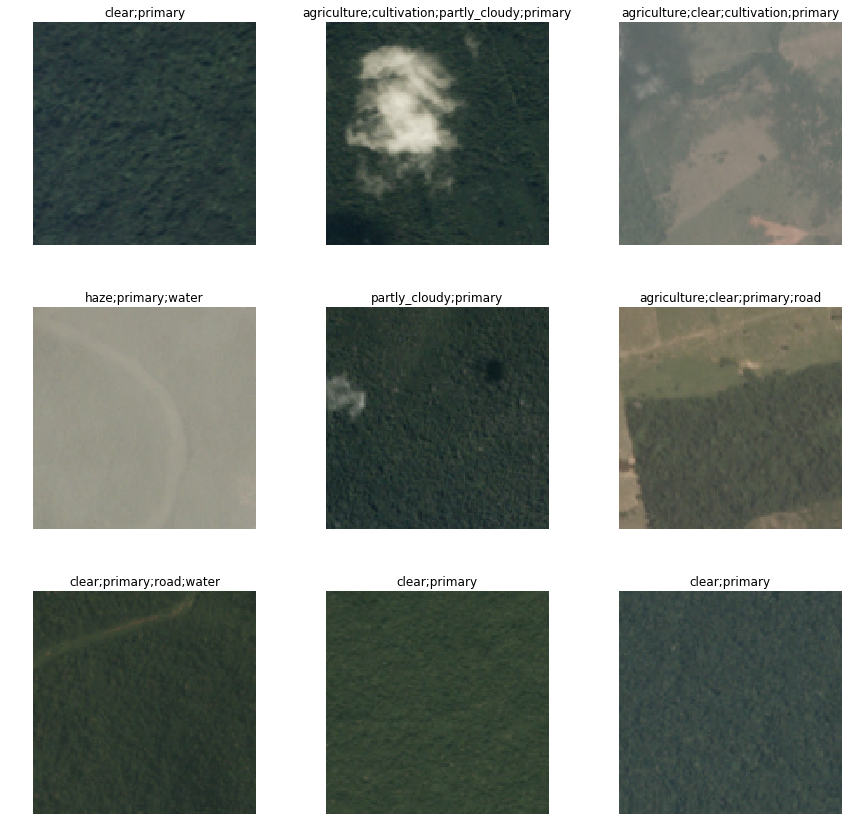

In [8]:
data.show_batch(rows = 3)

In [9]:
arch = models.resnet50

In [10]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score], path='../working/')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82512951.73it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


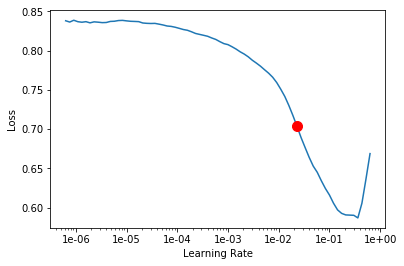

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(3, slice(2.29E-02,0.01))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.122489,0.129664,0.932355,0.882526
2,0.108216,0.096895,0.950471,0.915283
3,0.093343,0.087661,0.955681,0.923664


In [13]:
learn.save('stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


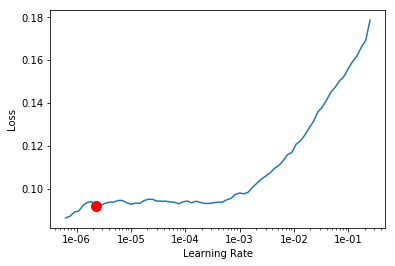

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(3, slice(7.59E-05))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.095962,0.086764,0.956327,0.924992
2,0.090990,0.086177,0.955862,0.925852
3,0.092229,0.085824,0.957577,0.926625


In [16]:
learn.save('stage-2-rn50')
learn.export()

> We can do transfer learning by changing the size of the data and learning using same **learner**. But Kaggle kernel gets Runtime error as of no sufficient memory

In [17]:
test = ImageItemList.from_folder(path/'test-jpg-v2').add(ImageImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [18]:
learn = load_learner('../working/', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [19]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [20]:
submission = pd.read_csv(path/'sample_submission_v2.csv')
submission['tags'] = labelled_preds
submission.to_csv('fastai_resnet50.csv')

In [21]:
print('Kernel Runtime: {0} minutes '.format((time.time() - start_time)/60.0))

Kernel Runtime: 33.00021281639735 minutes 
